# RISK Network Tutorial and Examples

Welcome to the **RISK** tutorial repository. This guide introduces `tutorial.ipynb`, a comprehensive walkthrough of **RISK (Regional Inference of Significant Kinships)** — a modular framework for biological network annotation and visualization. RISK integrates community detection algorithms, statistical overrepresentation analysis, and publication-quality plotting to support large-scale, reproducible network analysis.

Whether you're new to network analysis or aiming to explore advanced workflows, this tutorial covers key functionalities, practical examples, and reproducible pipelines.

---

## Yeast Protein–Protein Interaction (PPI) Network Demonstration

In this example, we apply RISK to the **yeast PPI network** from Michaelis _et al_., 2023, comprising **3,839 proteins** and **30,955 interactions**. This network serves as a benchmark for demonstrating how RISK identifies compact functional modules and performs annotation enrichment.

In this tutorial, we:

- **Cluster** the network using scalable community detection algorithms (e.g., Louvain, Leiden).
- **Evaluate** functional enrichment using overrepresentation tests such as hypergeometric and permutation.
- **Visualize** modules with contour overlays and publication-ready network layouts.

These steps illustrate RISK’s ability to resolve functional modules and reveal the organization of cellular processes such as ribosomal assembly, mitochondrial organization, and RNA polymerase activity.

---

## Tutorial Sections

- [0. Installing RISK](#0-installing-risk)  
- [1. Importing RISK](#1-importing-risk)  
- [2. Initializing RISK](#2-initializing-risk)  
- [3. Loading Networks into RISK](#3-loading-networks-into-risk)  
- [4. Loading Annotations into RISK](#4-loading-annotations-into-risk)  
- [5. Clustering Algorithms and Statistical Methods](#5-clustering-algorithms-and-statistical-methods)  
- [6. Building and Analyzing Results](#6-building-and-analyzing-results)  
- [7. Visualizing Networks in RISK](#7-visualizing-networks-in-risk)  
- [8. Overview of risk.params](#8-overview-of-riskparams)

---

## 0. Installing RISK

To get started with RISK, you'll need to install `risk-network` using `pip`. Run the following command in a code cell or terminal to install the latest version of the package:

##### [Back to Top](#risk-network-tutorial-and-examples)

In [1]:
# !pip install risk-network --upgrade

---

## 1. Importing RISK

After installing RISK, the next step is to import it into your notebook. You can verify that the installation was successful by checking the version of the package.

##### [Back to Top](#risk-network-tutorial-and-examples)

In [1]:
import risk

# Check the version of the RISK package to ensure it's installed correctly
risk.__version__

'0.0.14'

After verifying that the RISK package is installed and properly loaded, the next step is to import the `RISK` class. This class provides the core functionalities for performing biological network analysis.


In [2]:
from risk import RISK

**Notebook specific**: Detect and change to the notebook’s directory to enable relative paths

In [3]:
import os
from pathlib import Path

if "__file__" not in globals():
    os.chdir(Path().resolve())

**Notebook specific**: Use the `%matplotlib inline` magic command to display plots within the notebook

In [4]:
%matplotlib inline

---

## 2. Initializing RISK

This code block initializes a RISK object with specific parameters. Below is a description of each parameter:

#### Parameters
- `verbose` (bool): Controls whether log messages are printed. If `True`, log messages are printed to the console. Defaults to `True`.

##### [Back to Top](#risk-network-tutorial-and-examples)

In [5]:
# Initialize the RISK object

risk = RISK(verbose=True)

---

## 3. Loading Networks into RISK

Networks form the foundation of any RISK analysis, representing nodes (e.g., genes, proteins, papers) and the edges, or relationships, connecting them.

RISK provides flexible loading functions compatible with multiple formats—including Cytoscape session files, Cytoscape JSON exports, GPickle files, and in-memory NetworkX graphs. These loaders standardize input into NetworkX graph objects ready for downstream analysis, with options for preprocessing such as spherical projection, surface depth adjustment, and node filtering.

### Supported Network Formats

| Format                     | Method                     | Description                                                                 |
|----------------------------|----------------------------|-----------------------------------------------------------------------------|
| **Cytoscape (`.cys`)**     | `load_network_cytoscape`   | Import from Cytoscape session files; supports source/target labels and view selection. |
| **Cytoscape JSON (`.cyjs`)** | `load_network_cyjs`        | Import from Cytoscape JSON exports; specify source/target labels for nodes/edges. |
| **GPickle (`.gpickle`)**   | `load_network_gpickle`     | Reload networks serialized with GPickle; preserves complex structures.      |
| **NetworkX Graph**         | `load_network_networkx`    | Convert existing NetworkX objects into RISK-compatible format.              |

##### [Back to Top](#risk-network-tutorial-and-examples)

### Cytoscape Files (.cys)

Load Cytoscape session files exported from the desktop app.

#### Parameters

- **`filepath` (str)**: Path to the Cytoscape file.
- **`source_label` (str, optional)**: Source node label. Defaults to `"source"`.
- **`target_label` (str, optional)**: Target node label. Defaults to `"target"`.
- **`view_name` (str, optional)**: Specific view name to load. Defaults to `""`.
- **`compute_sphere` (bool, optional)**: Whether to map nodes from a 2D plane onto a 3D spherical surface using a Mercator projection. Defaults to `True`. This enables visualization of nodes on a sphere for improved spatial representation, particularly in applications where spatial relationships are crucial (e.g., networks with global-scale data or modular clustering).
- **`surface_depth` (float, optional)**: Adjusts the depth of nodes relative to the spherical surface, enhancing visualization of clustering. Defaults to `0.0`. Positive values pull clustered nodes closer to the center of the sphere, creating a clear visual distinction for denser regions. Negative values push nodes outward, emphasizing peripheral or sparse clusters while retaining their relative positions. A value of `0.0` keeps all nodes on the sphere's surface.
- **`min_edges_per_node` (int, optional)**: Minimum number of edges per node. Defaults to `0`.

#### Returns

- **`nx.Graph`**: The loaded and processed Cytoscape network as a NetworkX graph.


In [6]:
# Load the network from a Cytoscape file for RISK analysis

network = risk.load_network_cytoscape(
    filepath="./data/cytoscape/michaelis_2023.cys",
    source_label="source",
    target_label="target",
    view_name="",
    compute_sphere=True,
    surface_depth=0.1,
    min_edges_per_node=1,
)

---------------
Loading network
---------------
Filetype: Cytoscape
Filepath: ./data/cytoscape/michaelis_2023.cys
Minimum edges per node: 1
Projection: Sphere
Surface depth: 0.1
Initial node count: 3839
Final node count: 3839
Initial edge count: 30955
Final edge count: 30955


### Cytoscape JSON Files (.cyjs)

Load JSON exports from Cytoscape Web or JavaScript pipelines.

#### Parameters

- **`filepath` (str)**: Path to the Cytoscape JSON file.
- **`source_label` (str, optional)**: Source node label. Default is `"source"`.
- **`target_label` (str, optional)**: Target node label. Default is `"target"`.
- **`compute_sphere` (bool, optional)**: Whether to map nodes from a 2D plane onto a 3D spherical surface using a Mercator projection. Defaults to `True`. This enables visualization of nodes on a sphere for improved spatial representation, particularly in applications where spatial relationships are crucial (e.g., networks with global-scale data or modular clustering).
- **`surface_depth` (float, optional)**: Adjusts the depth of nodes relative to the spherical surface, enhancing visualization of clustering. Defaults to `0.0`. Positive values pull clustered nodes closer to the center of the sphere, creating a clear visual distinction for denser regions. Negative values push nodes outward, emphasizing peripheral or sparse clusters while retaining their relative positions. A value of `0.0` keeps all nodes on the sphere's surface.
- **`min_edges_per_node` (int, optional)**: Minimum number of edges per node. Defaults to `0`.

#### Returns

- **`nx.Graph`**: The loaded and processed Cytoscape JSON network as a NetworkX graph.


In [8]:
# Load the network from a Cytoscape JSON file for RISK analysis

network = risk.load_network_cyjs(
    filepath="./data/cyjs/michaelis_2023.cyjs",
    source_label="source",
    target_label="target",
    compute_sphere=True,
    surface_depth=0.1,
    min_edges_per_node=1,
)

---------------
Loading network
---------------
Filetype: Cytoscape JSON
Filepath: ./data/cyjs/michaelis_2023.cyjs
Minimum edges per node: 1
Projection: Sphere
Surface depth: 0.1
Initial node count: 3839
Final node count: 3839
Initial edge count: 30955
Final edge count: 30955


### GPickle Files (.gpickle)

Fast, Python-native serialization of NetworkX graphs preserving all attributes. Recommended for reproducibility and performance.

#### Parameters

- **`filepath` (str)**: Path to the GPickle file.
- **`compute_sphere` (bool, optional)**: Whether to map nodes from a 2D plane onto a 3D spherical surface using a Mercator projection. Defaults to `True`. This enables visualization of nodes on a sphere for improved spatial representation, particularly in applications where spatial relationships are crucial (e.g., networks with global-scale data or modular clustering).
- **`surface_depth` (float, optional)**: Adjusts the depth of nodes relative to the spherical surface, enhancing visualization of clustering. Defaults to `0.0`. Positive values pull clustered nodes closer to the center of the sphere, creating a clear visual distinction for denser regions. Negative values push nodes outward, emphasizing peripheral or sparse clusters while retaining their relative positions. A value of `0.0` keeps all nodes on the sphere's surface.
- **`min_edges_per_node` (int, optional)**: Minimum number of edges per node. Defaults to `0`.

#### Returns

- **`nx.Graph`**: The loaded and processed GPickle network as a NetworkX graph.


In [10]:
# Load the network from a GPickle file for RISK analysis

network = risk.load_network_gpickle(
    filepath="./data/gpickle/michaelis_2023.gpickle",
    compute_sphere=True,
    surface_depth=0.1,
    min_edges_per_node=1,
)

---------------
Loading network
---------------
Filetype: GPickle
Filepath: ./data/gpickle/michaelis_2023.gpickle
Minimum edges per node: 1
Projection: Sphere
Surface depth: 0.1
Initial node count: 3839
Final node count: 3839
Initial edge count: 30955
Final edge count: 30955


### NetworkX Graphs

Load from an in-memory `networkx.Graph`. Integrates seamlessly when the graph is already loaded.

#### Parameters

- **`network` (nx.Graph)**: A NetworkX graph object.
- **`compute_sphere` (bool, optional)**: Whether to map nodes from a 2D plane onto a 3D spherical surface using a Mercator projection. Defaults to `True`. This enables visualization of nodes on a sphere for improved spatial representation, particularly in applications where spatial relationships are crucial (e.g., networks with global-scale data or modular clustering).
- **`surface_depth` (float, optional)**: Adjusts the depth of nodes relative to the spherical surface, enhancing visualization of clustering. Defaults to `0.0`. Positive values pull clustered nodes closer to the center of the sphere, creating a clear visual distinction for denser regions. Negative values push nodes outward, emphasizing peripheral or sparse clusters while retaining their relative positions. A value of `0.0` keeps all nodes on the sphere's surface.
- **`min_edges_per_node` (int, optional)**: Minimum number of edges per node. Defaults to `0`.

#### Returns

- **`nx.Graph`**: The loaded and processed NetworkX graph.


In [12]:
# Load the network from a NetworkX graph for RISK analysis

network = risk.load_network_networkx(
    network=network,
    compute_sphere=True,
    surface_depth=0.1,
    min_edges_per_node=1,
)

---------------
Loading network
---------------
Filetype: NetworkX
Minimum edges per node: 1
Projection: Sphere
Surface depth: 0.1
Initial node count: 3839
Final node count: 3839
Initial edge count: 30955
Final edge count: 30955


---

## 4. Loading Annotations into RISK

Annotations provide the biological context for RISK by linking network clusters to functional terms (e.g., cellular components, metabolic pathways, protein complexes). They enable downstream statistical tests to evaluate whether specific functions are overrepresented within detected network clusters.

Annotations must be provided by the user and formatted clearly to ensure compatibility with RISK loaders. We note that RISK does not bundle annotations; users should obtain curated resources such as Gene Ontology (GO) (Ashburner _et al_., 2000), CORUM (Tsitsiridis _et al_., 2022), or KEGG (Kanehisa _et al_., 2023) and format them as term–to–node (e.g., genes/proteins) membership tables. Publicly available resources such as Gene Ontology, CORUM, and KEGG offer standardized annotation files that can be adapted for use.

For example, a simple JSON/dictionary representation could be:

```json
{
  "proline biosynthetic process": ["CAR2", "PRO1", "PRO2", "PRO3", "YHR033W"],
  "glyoxylate metabolic process": ["DAL7", "GOR1", "ICL1", "IDP1", "IDP2", "IDP3", "LEU2", "MDH3", "MLS1"]
}
```

### Supported Annotation Formats

| Format    | Method                      | Description                                      |
|-----------|-----------------------------|--------------------------------------------------|
| **JSON**  | `load_annotation_json`      | Import annotations from a JSON term–to–gene mapping file. |
| **CSV**   | `load_annotation_csv`       | Import from a CSV file (supports custom delimiters).       |
| **TSV**   | `load_annotation_tsv`       | Import from a tab-separated file.                           |
| **Excel** | `load_annotation_excel`     | Import annotations from a specified sheet in an XLSX file. |

##### [Back to Top](#risk-network-tutorial-and-examples)

### JSON Files (.json)

Load annotation data from a JSON file and associate terms with network nodes.

#### Parameters

- **`network` (NetworkX graph)**: The network to which the annotation is related.
- **`filepath` (str)**: Path to the JSON annotation file.
- **`min_nodes_per_term` (int, optional)**: The minimum number of network nodes required for each annotation term to be included. Defaults to `1`.
- **`max_nodes_per_term` (int, optional)**: The maximum number of network nodes required for each annotation term to be included. Defaults to `10_000`.

#### Returns

- **`dict`**: A dictionary containing ordered nodes, ordered annotations, and the annotation matrix.


In [7]:
# Load GO Biological Process (BP) annotations from a JSON file and associate them with the existing network

annotation = risk.load_annotation_json(
    network=network,
    filepath="./data/json/annotation/go_biological_process.json",
    min_nodes_per_term=5,
    max_nodes_per_term=75,
)

# Note: You can also load other GO annotations, such as:
# - 'go_cellular_component.json' for GO Cellular Component (CC) annotations
# - 'go_molecular_function.json' for GO Molecular Function (MF) annotations

------------------
Loading annotation
------------------
Filetype: JSON
Filepath: ./data/json/annotation/go_biological_process.json
Minimum number of nodes per annotation term: 5
Maximum number of nodes per annotation term: 75
Number of input annotation terms: 2214
Number of remaining annotation terms: 1293


### CSV Files (.csv)

Load annotation data from a CSV file, specifying columns and delimiter for nodes.

#### Parameters

- **`network` (nx.Graph)**: The NetworkX graph to which the annotation is related.
- **`filepath` (str)**: Path to the CSV annotation file.
- **`label_colname` (str)**: Name of the column containing the labels (e.g., GO terms).
- **`nodes_colname` (str)**: Name of the column containing the nodes associated with each label.
- **`nodes_delimiter` (str, optional)**: Delimiter used to separate multiple nodes within the nodes column. Defaults to `';'`.
- **`min_nodes_per_term` (int, optional)**: The minimum number of network nodes required for each annotation term to be included. Defaults to `1`.
- **`max_nodes_per_term` (int, optional)**: The maximum number of network nodes required for each annotation term to be included. Defaults to `10_000`.

#### Returns

- **`dict`**: A dictionary containing ordered nodes, ordered annotations, and the annotation matrix.


In [14]:
# Load GO Biological Process (BP) annotations from a CSV file and associate them with the existing network

annotation = risk.load_annotation_csv(
    network=network,
    filepath="./data/csv/annotation/go_biological_process.csv",
    label_colname="label",
    nodes_colname="nodes",
    nodes_delimiter=";",
    min_nodes_per_term=5,
    max_nodes_per_term=75,
)

# Note: You can also load other GO annotations using similar filenames, such as:
# - 'go_cellular_component.csv' for GO Cellular Component (CC) annotations
# - 'go_molecular_function.csv' for GO Molecular Function (MF) annotations

------------------
Loading annotation
------------------
Filetype: CSV
Filepath: ./data/csv/annotation/go_biological_process.csv
Minimum number of nodes per annotation term: 5
Maximum number of nodes per annotation term: 75
Number of input annotation terms: 2214
Number of remaining annotation terms: 1293


### TSV Files (.tsv)

Load annotation data from a tab-delimited file, similar to CSV but with tabs as separators.

#### Parameters

- **`network` (nx.Graph)**: The NetworkX graph to which the annotation is related.
- **`filepath` (str)**: Path to the TSV annotation file.
- **`label_colname` (str)**: Name of the column containing the labels (e.g., GO terms).
- **`nodes_colname` (str)**: Name of the column containing the nodes associated with each label.
- **`nodes_delimiter` (str, optional)**: Delimiter used to separate multiple nodes within the nodes column. Defaults to `';'`.
- **`min_nodes_per_term` (int, optional)**: The minimum number of network nodes required for each annotation term to be included. Defaults to `1`.
- **`max_nodes_per_term` (int, optional)**: The maximum number of network nodes required for each annotation term to be included. Defaults to `10_000`.

#### Returns

- **`dict`**: A dictionary containing ordered nodes, ordered annotations, and the annotations matrix.


In [15]:
# Load GO Biological Process (BP) annotations from a TSV file and associate them with the existing network

annotation = risk.load_annotation_tsv(
    network=network,
    filepath="./data/tsv/annotation/go_biological_process.tsv",
    label_colname="label",
    nodes_colname="nodes",
    nodes_delimiter=";",
    min_nodes_per_term=5,
    max_nodes_per_term=75,
)

# Note: You can also load other GO annotations using similar filenames, such as:
# - 'go_cellular_component.tsv' for GO Cellular Component (CC) annotations
# - 'go_molecular_function.tsv' for GO Molecular Function (MF) annotations

------------------
Loading annotation
------------------
Filetype: TSV
Filepath: ./data/tsv/annotation/go_biological_process.tsv
Minimum number of nodes per annotation term: 5
Maximum number of nodes per annotation term: 75
Number of input annotation terms: 2214
Number of remaining annotation terms: 1293


### Excel Files (.xlsx, .xls)

Load annotation data from an Excel workbook, with support for selecting specific sheets.

#### Parameters

- **`network` (nx.Graph)**: The NetworkX graph to which the annotation are related.
- **`filepath` (str)**: Path to the Excel annotation file.
- **`label_colname` (str)**: Name of the column containing the labels (e.g., GO terms).
- **`nodes_colname` (str)**: Name of the column containing the nodes associated with each label.
- **`sheet_name` (str, optional)**: The name of the Excel sheet to load. Defaults to `'Sheet1'`.
- **`nodes_delimiter` (str, optional)**: Delimiter used to separate multiple nodes within the nodes column. Defaults to `';'`.
- **`min_nodes_per_term` (int, optional)**: The minimum number of network nodes required for each annotation term to be included. Defaults to `1`.
- **`max_nodes_per_term` (int, optional)**: The maximum number of network nodes required for each annotation term to be included. Defaults to `10_000`.

#### Returns

- **`dict`**: A dictionary containing ordered nodes, ordered annotations, and the annotations matrix.


In [16]:
# Load GO Biological Process (BP) annotations from an Excel file and associate them with the existing network

annotation = risk.load_annotation_excel(
    network=network,
    filepath="./data/excel/annotation/go_biological_process.xlsx",
    label_colname="label",
    nodes_colname="nodes",
    sheet_name="Sheet1",
    nodes_delimiter=";",
    min_nodes_per_term=5,
    max_nodes_per_term=75,
)

# Note: You can also load other GO annotations using similar filenames, such as:
# - 'go_cellular_component.xlsx' for GO Cellular Component (CC) annotations
# - 'go_molecular_function.xlsx' for GO Molecular Function (MF) annotations

------------------
Loading annotation
------------------
Filetype: Excel
Filepath: ./data/excel/annotation/go_biological_process.xlsx
Minimum number of nodes per annotation term: 5
Maximum number of nodes per annotation term: 75
Number of input annotation terms: 2214
Number of remaining annotation terms: 1293


### Dictionary Annotation

Load annotation data already in memory as a Python dictionary.

#### Parameters

- **`network` (nx.Graph)**: The NetworkX graph to which the annotation are related.
- **`content` (dict)**: The annotation dictionary to load.
- **`min_nodes_per_term` (int, optional)**: The minimum number of network nodes required for each annotation term to be included. Defaults to `1`.
- **`max_nodes_per_term` (int, optional)**: The maximum number of network nodes required for each annotation term to be included. Defaults to `10_000`.

#### Returns

- **`dict`**: A dictionary containing ordered nodes, ordered annotations, and the annotation matrix.


In [17]:
# Load the JSON file into a dictionary, then use the dictionary to load annotations

import json

json_file_path = "./data/json/annotation/go_biological_process.json"
with open(json_file_path, "r") as file:
    annotation_dict = json.load(file)

# Use the loaded dictionary with the load_annotation_dict method
annotation = risk.load_annotation_dict(
    network=network,
    content=annotation_dict,
    min_nodes_per_term=5,
    max_nodes_per_term=75,
)

------------------
Loading annotation
------------------
Filetype: Dictionary
Filepath: In-memory dictionary
Minimum number of nodes per annotation term: 5
Maximum number of nodes per annotation term: 75
Number of input annotation terms: 2214
Number of remaining annotation terms: 1293


---

## 5. Clustering Algorithms and Statistical Methods

Clustering algorithms detect structured regions of varying size and compactness, while statistical methods evaluate overrepresentation of biological terms within these regions. The choice of algorithm or test depends on network scale, density, and biological context, influencing the resolution, granularity, and rigor of the resulting modules and overrepresentation results.

### Summary of Clustering Methods
Before applying statistical tests, RISK groups nodes into modules using community detection. Each algorithm has strengths for different network sizes and contexts.

| Algorithm             | Speed  | Primary use                                | When/Why (assumptions & notes)                                                                                              |
| --------------------- | ------ | ------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------- |
| Louvain               | Fast   | Default, scalable to very large networks   | Greedy modularity optimization (Blondel et al., 2008); efficient for >10⁴ nodes; may produce disconnected subclusters.     |
| Leiden                | Fast   | Improved Louvain with better resolution    | Guarantees well-connected communities; more stable than Louvain (Traag et al., 2019); slightly higher runtime.             |
| Markov Clustering     | Medium | Detect smaller, compact complexes          | Flow-based algorithm (Van Dongen, 2008); good for protein complexes or tightly connected submodules.                       |
| Walktrap              | Medium | Hierarchical detection in mid-sized graphs | Random-walk based (Pons & Latapy, 2005); effective for local structure; slower on >10⁴ nodes.                              |
| Greedy Modularity     | Fast   | Coarse partitioning                        | Optimizes modularity via agglomeration; very fast but suffers from resolution limit (Newman, 2004).                        |
| Label Propagation     | Fast   | Quick heuristic                            | Unsupervised label spreading; no objective function; non-deterministic and unstable (Raghavan et al., 2007).               |
| Spinglass             | Slow   | Small networks; theoretical interest       | Statistical mechanics approach (Reichardt & Bornholdt, 2006); finds communities by simulating spin states; computationally intensive. |

---

### Summary of Statistical Tests
RISK implements a suite of statistical tests—ranging from fast approximations to rigorous overrepresentation analysis—to assess functional term enrichment in network neighborhoods. Each method has strengths depending on dataset size, structure, and precision requirements.

| Test           | Speed  | Primary use                           | When/Why (assumptions & notes)                                                                                                   |
| -------------- | ------ | ------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------- |
| Permutation    | Slow   | Most rigorous; non-parametric         | Distribution-free empirical null (permute network or labels); preferred when assumptions are unclear; computationally intensive. |
| Hypergeometric | Medium | Standard for GO/pathway enrichment    | Exact test for finite populations sampled without replacement; widely used for term–to–gene membership tables.                   |
| Chi-squared    | Fast   | Approximate contingency-table testing | Suitable for large samples with expected counts ≥ 5 per cell; fast but approximate; avoid with sparse/low counts.                |
| Binomial       | Fast   | Scalable approximation                | Fast approximation assuming independent trials/with-replacement; useful for large populations with small samples.                |

---

### Applying Clustering and Statistical Tests
RISK exposes clustering and statistical functions for flexible workflows:

- **Clustering**: Choose an algorithm via `distance_metric` (e.g., `"louvain"`, `"leiden"`, `"markov_clustering"`).  
- **Statistical Tests**: Apply one of the following functions:  
  - `load_neighborhoods_permutation`  
  - `load_neighborhoods_hypergeom`  
  - `load_neighborhoods_chi2`
  - `load_neighborhoods_binom`  

Clustering defines the modules; statistical tests assess their biological significance.

##### [Back to Top](#risk-network-tutorial-and-examples)

### Permutation Test

Builds an empirical null by permuting either the network structure or annotation labels.

#### Parameters

- **`network` (nx.Graph)**: The network graph.
- **`annotation` (dict)**: The annotation associated with the network.
- **`distance_metric` (str, list, tuple, or np.ndarray, optional)**: Method(s) used to compute distances for community detection. You can specify a single method or a list/tuple/array of methods to apply multiple community detection algorithms. Options include:
  - `'louvain'`: Applies the Louvain method for community detection. *(default)*
  - `'greedy_modularity'`: Detects communities in a graph based on the greedy optimization of modularity.
  - `'label_propagation'`: Uses label propagation to find communities.
  - `'leiden'`: Applies the Leiden method for community detection.
  - `'markov_clustering'`: Implements the Markov Clustering Algorithm.
  - `'spinglass'`: Community detection based on the spinglass model.
  - `'walktrap'`: Detects communities via random walks.
- **`louvain_resolution` (float, optional)**: Resolution parameter for the Louvain method. Only applies if `'louvain'` is one of the distance metrics. Defaults to `0.1`.
- **`leiden_resolution` (float, optional)**: Resolution parameter for the Leiden method. Only applies if `'leiden'` is one of the distance metrics. Defaults to `1.0`.
- **`fraction_shortest_edges` (float, list, tuple, or np.ndarray, optional)**: Shortest edge rank fraction threshold(s) for creating subgraphs. Can be a single float for one threshold or a list/tuple of floats corresponding to multiple thresholds. Defaults to `0.5`.
- **`score_metric` (str, optional)**: Metric used to score neighborhoods. Options include:
  - `'sum'`: Sums the annotation values within each neighborhood. *(default)*
  - `'stdev'`: Computes the standard deviation of annotation values within each neighborhood.
- **`null_distribution` (str, optional)**: Defines the type of null distribution to use for comparison. Options include:
  - `'network'`: Randomly permuted network structure. *(default)*
  - `'annotation'`: Randomly permuted annotations.
- **`num_permutations` (int, optional)**: Number of permutations for significance testing. Defaults to `1000`.
- **`random_seed` (int, optional)**: Seed for random number generation in permutation test. Defaults to `888`.
- **`max_workers` (int, optional)**: Maximum number of workers for parallel computation. Defaults to `1`.

#### Returns

- **`dict`**: A dictionary containing the computed significance of neighborhoods within the network.


In [8]:
# Perform annotation significance analysis by computing p-values for network neighborhoods using the permutation test

neighborhoods = risk.load_neighborhoods_permutation(
    network=network,
    annotation=annotation,
    distance_metric="louvain",
    louvain_resolution=5.0,
    leiden_resolution=1.0,
    fraction_shortest_edges=0.225,
    score_metric="stdev",
    null_distribution="network",
    num_permutations=1_000,
    random_seed=887,
    max_workers=4,
)

------------------------
Running permutation test
------------------------
Neighborhood scoring metric: 'stdev'
Number of permutations: 1000
Maximum workers: 4
Null distribution: 'network'
Distance metric: 'louvain (resolution=5.0)'
Edge length threshold: 0.225
Random seed: 887


Total progress: 100%|████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.30it/s]


### Hypergeometric Test

Exact test based on finite sampling without replacement.

#### Parameters

- **`network` (nx.Graph)**: The network graph.
- **`annotation` (dict)**: The annotation associated with the network.
- **`distance_metric` (str, list, tuple, or np.ndarray, optional)**: Method(s) used to compute distances for community detection. You can specify a single method or a list/tuple/array of methods to apply multiple community detection algorithms. Options include:
  - `'louvain'`: Applies the Louvain method for community detection. *(default)*
  - `'greedy_modularity'`: Detects communities in a graph based on the greedy optimization of modularity.
  - `'label_propagation'`: Uses label propagation to find communities.
  - `'leiden'`: Applies the Leiden method for community detection.
  - `'markov_clustering'`: Implements the Markov Clustering Algorithm.
  - `'walktrap'`: Detects communities via random walks.
  - `'spinglass'`: Community detection based on the spinglass model.
- **`louvain_resolution` (float, optional)**: Resolution parameter for the Louvain method. Only applies if `'louvain'` is one of the distance metrics. Defaults to `0.1`.
- **`leiden_resolution` (float, optional)**: Resolution parameter for the Leiden method. Only applies if `'leiden'` is one of the distance metrics. Defaults to `1.0`.
- **`fraction_shortest_edges` (float, list, tuple, or np.ndarray, optional)**: Shortest edge rank fraction threshold(s) for creating subgraphs. Can be a single float for one threshold or a list/tuple of floats corresponding to multiple thresholds. Defaults to `0.5`.
- **`null_distribution` (str, optional)**: Defines the type of null distribution to use for comparison. Options include:
  - `'network'`: Randomly permuted network structure. *(default)*
  - `'annotation'`: Randomly permuted annotations.
- **`random_seed` (int, optional)**: Seed for random number generation in permutation test. Defaults to `888`.

#### Returns

- **`dict`**: A dictionary containing the computed significance of neighborhoods within the network.


In [20]:
# Perform annotation significance analysis by computing p-values for network neighborhoods using the hypergeometric test

neighborhoods = risk.load_neighborhoods_hypergeom(
    network=network,
    annotation=annotation,
    distance_metric="louvain",
    louvain_resolution=5.0,
    leiden_resolution=1.0,
    fraction_shortest_edges=0.225,
    null_distribution="network",
    random_seed=887,
)

---------------------------
Running hypergeometric test
---------------------------
Null distribution: 'network'
Distance metric: 'louvain (resolution=5.0)'
Edge length threshold: 0.25
Random seed: 887


### Chi-squared Test

Evaluates significance using contingency tables.

#### Parameters

- **`network` (nx.Graph)**: The network graph.
- **`annotation` (dict)**: The annotation associated with the network.
- **`distance_metric` (str, list, tuple, or np.ndarray, optional)**: Method(s) used to compute distances for community detection. You can specify a single method or a list/tuple/array of methods to apply multiple community detection algorithms. Options include:
  - `'louvain'`: Applies the Louvain method for community detection. *(default)*
  - `'greedy_modularity'`: Detects communities in a graph based on the greedy optimization of modularity.
  - `'label_propagation'`: Uses label propagation to find communities.
  - `'leiden'` Applies the Leiden method for community detection.
  - `'markov_clustering'`: Implements the Markov Clustering Algorithm.
  - `'walktrap'`: Detects communities via random walks.
  - `'spinglass'`: Community detection based on the spinglass model.
- **`louvain_resolution` (float, optional)**: Resolution parameter for the Louvain method. Only applies if `'louvain'` is one of the distance metrics. Defaults to `0.1`.
- **`leiden_resolution` (float, optional)**: Resolution parameter for Leiden clustering. Only applies if `'leiden'` is one of the distance metrics. Defaults to `1.0`.
- **`fraction_shortest_edges` (float, list, tuple, or np.ndarray, optional)**: Shortest edge rank fraction threshold(s) for creating subgraphs. Can be a single float for one threshold or a list/tuple of floats corresponding to multiple thresholds. Defaults to `0.5`.
- **`null_distribution` (str, optional)**: Defines the type of null distribution to use for comparison. Options include:
  - `'network'`: Randomly permuted network structure. *(default)*
  - `'annotation'`: Randomly permuted annotations.
- **`random_seed` (int, optional)**: Seed for random number generation in permutation test. Defaults to `888`.

#### Returns

- **`dict`**: A dictionary containing the computed significance of neighborhoods within the network.


In [22]:
# Perform annotation significance analysis by computing p-values for network neighborhoods using chi-squared test

neighborhoods = risk.load_neighborhoods_chi2(
    network=network,
    annotation=annotation,
    distance_metric="louvain",
    louvain_resolution=5.0,
    leiden_resolution=1.0,
    fraction_shortest_edges=0.225,
    null_distribution="network",
    random_seed=887,
)

------------------------
Running chi-squared test
------------------------
Null distribution: 'network'
Distance metric: 'louvain (resolution=5.0)'
Edge length threshold: 0.25
Random seed: 887


### Binomial Test

Fast approximation to overrepresentation based on independent trials.

#### Parameters

- **`network` (nx.Graph)**: The network graph.
- **`annotation` (dict)**: The annotation associated with the network.
- **`distance_metric` (str, list, tuple, or np.ndarray, optional)**: Method(s) used to compute distances for community detection. You can specify a single method or a list/tuple/array of methods to apply multiple community detection algorithms. Options include:
  - `'louvain'`: Applies the Louvain method for community detection. *(default)*
  - `'greedy_modularity'`: Detects communities in a graph based on the greedy optimization of modularity.
  - `'label_propagation'`: Uses label propagation to find communities.
  - `'leiden'` Applies the Leiden method for community detection.
  - `'markov_clustering'`: Implements the Markov Clustering Algorithm.
  - `'walktrap'`: Detects communities via random walks.
  - `'spinglass'`: Community detection based on the spinglass model.
- **`louvain_resolution` (float, optional)**: Resolution parameter for the Louvain method. Only applies if `'louvain'` is one of the distance metrics. Defaults to `0.1`.
- **`leiden_resolution` (float, optional)**: Resolution parameter for Leiden clustering. Only applies if `'leiden'` is one of the distance metrics. Defaults to `1.0`.
- **`fraction_shortest_edges` (float, list, tuple, or np.ndarray, optional)**: Shortest edge rank fraction threshold(s) for creating subgraphs. Can be a single float for one threshold or a list/tuple of floats corresponding to multiple thresholds. Defaults to `0.5`.
- **`null_distribution` (str, optional)**: Defines the type of null distribution to use for comparison. Options include:
  - `'network'`: Randomly permuted network structure. *(default)*
  - `'annotation'`: Randomly permuted annotations.
- **`random_seed` (int, optional)**: Seed for random number generation in permutation test. Defaults to `888`.

#### Returns

- **`dict`**: A dictionary containing the computed significance of neighborhoods within the network.


In [21]:
# Perform annotation significance analysis by computing p-values for network neighborhoods using binomial test

neighborhoods = risk.load_neighborhoods_binom(
    network=network,
    annotation=annotation,
    distance_metric="louvain",
    louvain_resolution=5.0,
    leiden_resolution=1.0,
    fraction_shortest_edges=0.225,
    null_distribution="network",
    random_seed=887,
)

---------------------
Running binomial test
---------------------
Null distribution: 'network'
Distance metric: 'louvain (resolution=5.0)'
Edge length threshold: 0.25
Random seed: 887


---

## 6. Building and Analyzing Results

The `NetworkGraph` object integrates network data, annotations, and overrepresentation results into a unified structure, supporting clustering, domain-level significance, and downstream visualization. The `load_graph` function generates a `NetworkGraph` object for analyzing the network. This function integrates various network components, such as clusters with overrepresented annotation terms, and provides options to customize clustering and analysis parameters.

#### Parameters

- **`network` (nx.Graph)**: The network graph containing the nodes and edges to be analyzed.
- **`annotation` (dict)**: The annotation associated with the network, typically derived from biological or functional data.
- **`neighborhoods` (dict)**: The neighborhoods object, containing data from enrichment or depletion analysis.
- **`tail` (str, optional)**: Specifies the tail of the statistical test to use. Options include:
  - `'right'`: For enrichment. *(default)*
  - `'left'`: For depletion.
  - `'both'`: For two-tailed analysis.
- **`pval_cutoff` (float, optional)**: Cutoff value for p-values to determine significance. Defaults to `0.01`.
  - **Range**: Any value between 0 and 1.
- **`fdr_cutoff` (float, optional)**: Cutoff value for FDR-corrected p-values. Defaults to `0.9999`.
  - **Range**: Any value between 0 and 1.
- **`impute_depth` (int, optional)**: Depth for imputing missing values. Defaults to `1`.
  - **Range**: Any whole number greater than or equal to 0.
- **`prune_threshold` (float, optional)**: Threshold for pruning weak edges from the network graph. Defaults to `0.0`.
  - **Range**: Any value between 0 and 1.
- **`linkage_criterion` (str, optional)**: Criterion for clustering. Defaults to `'distance'`.
  - **Options**:
    - `'distance'`: Clusters are formed based on distance.
    - `'maxclust'`: Clusters are formed based on the maximum number of clusters.
    - `'off'`: Disable clustering. If selected, individual annotation terms will not be consolidated on the network.
- **`linkage_method` (str, optional)**: Method used for hierarchical clustering. Defaults to `'average'`.
  - **Options**:
    - `'auto'`: Automatically determines the optimal method using the silhouette score.
    - Other options: `'single'`, `'complete'`, `'average'`, `'weighted'`, `'centroid'`, `'median'`, `'ward'`.
- **`linkage_metric` (str, optional)**: Distance metric used for clustering. Defaults to `'yule'`.
  - **Options**:
    - `'auto'`: Automatically determines the optimal metric using the silhouette score.
    - Other options: `'braycurtis'`, `'canberra'`, `'chebyshev'`, `'cityblock'`, `'correlation'`, `'cosine'`, `'dice'`, `'euclidean'`, `'hamming'`, `'jaccard'`, `'jensenshannon'`, `'kulczynski1'`, `'mahalanobis'`, `'matching'`, `'minkowski'`, `'rogerstanimoto'`, `'russellrao'`, `'seuclidean'`, `'sokalmichener'`, `'sokalsneath'`, `'sqeuclidean'`, `'yule'`.
- **`linkage_threshold` (str or float, optional)**: The cutoff distance for forming flat clusters in hierarchical clustering. Accepts either a numeric threshold or `'auto'` to enable automatic threshold optimization using the silhouette score. Defaults to `0.2`.
  - **Range**: Any value between 0 and 1.
- **`min_cluster_size` (int, optional)**: Minimum size of clusters to be formed. Defaults to `5`.
- **`max_cluster_size` (int, optional)**: Maximum size of clusters to be formed. Defaults to `1000`.

#### Returns

- **`NetworkGraph`**: A `NetworkGraph` object representing the processed network, ready for analysis and visualization.

##### [Back to Top](#risk-network-tutorial-and-examples)

In [9]:
# Get the NetworkGraph object for plotting

graph = risk.load_graph(
    network=network,
    annotation=annotation,
    neighborhoods=neighborhoods,
    tail="right",
    pval_cutoff=0.01,
    fdr_cutoff=1.00,
    impute_depth=0,
    prune_threshold=0.1,
    linkage_criterion="distance",
    linkage_method="single",
    linkage_metric="sokalmichener",
    linkage_threshold=0.063,
    min_cluster_size=5,
    max_cluster_size=1_000,
)

---------------------------------
Finding significant neighborhoods
---------------------------------
p-value cutoff: 0.01
FDR BH cutoff: 1.0
Significance tail: 'right' (enrichment)
------------------------
Processing neighborhoods
------------------------
Imputation depth: 0
Pruning threshold: 0.1
-----------------------
Finding top annotations
-----------------------
Min cluster size: 5
Max cluster size: 1000
-----------------------------------------
Optimizing distance threshold for domains
-----------------------------------------


Evaluating linkage methods and metrics: 100%|█████████████████████████████████████████| 1/1 [00:00<00:00]

Linkage criterion: 'distance'
Linkage method: 'single'
Linkage metric: 'sokalmichener'
Linkage threshold: 0.063


## 6a. NetworkGraph Methods

The `NetworkGraph` object in RISK provides essential methods for managing network data structures. These methods enable the organization of domains and significance data, making it easier to handle clusters, significance scores, and annotations in the network.

- **`pop`**: This method removes a specified domain ID and its associated data from all internal mappings within `NetworkGraph`, and returns the domain's **node labels**. It effectively "cleans up" that domain from the network while maintaining internal consistency.


In [ ]:
# Remove every reference to Domain ID 1 from the NetworkGraph instance and retrieve the associated node labels

# domain_1_labels =  graph.pop(1)

## 6b. NetworkGraph Attributes

After computing cluster significance for terms, the `NetworkGraph` object in RISK holds several key attributes that organize the network's nodes, domains, and significance data. These attributes not only support the structure of the network but also enable flexible analysis and visualization, ensuring that significant clusters and annotations are correctly mapped.

- **`domain_id_to_node_ids_map` (dict)**: Maps each domain (cluster or group of nodes) to the node IDs it contains, helping to identify which nodes belong to each domain in the network.
- **`domain_id_to_node_labels_map` (dict)**: Connects domain IDs to the node labels within each cluster, useful for grouping nodes by their labels for visualization.
- **`domain_id_to_domain_terms_map` (dict)**: Links each domain to its significant terms, providing insight into the functional significance of the clusters.
- **`domain_id_to_domain_info_map` (dict)**: Associates each domain with a detailed description and its significance score, offering a comprehensive view of the domain's attributes.
- **`node_id_to_node_label_map` (dict)**: A reverse lookup connecting node IDs back to their labels, ensuring clarity during visualization and analysis.
- **`node_label_to_significance_map` (dict)**: Associates each node label with its significance score, facilitating interpretation of the network’s significant nodes.
- **`node_label_to_node_id_map` (dict)**: Maps node labels to node IDs, providing easy conversion between labels and internal node identifiers.
- **`node_significance_sums` (numpy.ndarray)**: Contains significance values for each node in a 1D array, reflecting the strength of significance across the network and highlighting the most significant nodes.

These attributes form the backbone of the RISK tool, allowing multiple statistical tests and visualizations to be generated and integrated into one cohesive network. Whether running permutation tests, hypergeometric tests, or visualizing significant subgraphs, these mappings ensure that all analyses remain consistent and unified under a single master network. By supporting iterative testing and clear organization of nodes and domains, these attributes make RISK a powerful tool for uncovering meaningful patterns and insights in network data.


In [54]:
# Fetching key NetworkGraph attributes from the graph object

domain_id_to_node_ids_map = graph.domain_id_to_node_ids_map
domain_id_to_node_labels_map = graph.domain_id_to_node_labels_map
domain_id_to_domain_terms_map = graph.domain_id_to_domain_terms_map
domain_id_to_domain_info_map = graph.domain_id_to_domain_info_map

node_id_to_node_label_map = graph.node_id_to_node_label_map
node_label_to_significance_map = graph.node_label_to_significance_map
node_label_to_node_id_map = graph.node_label_to_node_id_map

node_significance_sums = graph.node_significance_sums

## 6c. NetworkGraph Analysis Summary

The `summary` method in the `NetworkGraph` object in RISK is designed to process, store, and export analysis results, including significance and depletion data. It provides methods to load and structure domain information into a DataFrame, as well as export the processed data to various file formats for reporting.

### Loading Results

The `load` method loads and processes domain and annotation data into a DataFrame, applying FDR correction to p-values and structuring the data for significance metrics.

#### Returns

- **`pd.DataFrame`**: A DataFrame containing processed significance scores, p-values, q-values, and annotation membership information.


In [55]:
# Load the analysis summary into a DataFrame

loaded_summary = graph.summary.load()
loaded_summary.head()

------------------------
Loading analysis summary
------------------------


,Annotation,Domain ID,Matched Members,Matched Count,Summed Significance Score,Enrichment P-value,Enrichment Q-value,Depletion P-value,Depletion Q-value
0,maintenance of protein location in cell,18,BRE5;DID4;EMP24;EPS1;ERD2;ERP1;ERP2;ERP3;ERP4;...,28,93.0,0.001,0.099462,0.962,1.0
1,mRNA splice site recognition,50,CDC40;ISY1;LUC7;NAM8;PRP28;PRP39;PRP42;PRP8;PR...,11,189.0,0.001,0.215500,1.000,1.0
2,transsulfuration,-1,,0,0.0,1.000,1.000000,1.000,1.0
3,signal peptide processing,-1,,0,0.0,1.000,1.000000,1.000,1.0
4,regulation of phosphatidylinositol dephosphory...,-1,,0,0.0,1.000,1.000000,1.000,1.0


### Exporting Analysis Summary to CSV

The `to_csv` method exports the loaded analysis summary to a CSV file, making it easy to share and analyze the data.

#### Parameters

- **`filepath` (str)**: The path where the CSV file will be saved.

In [10]:
# Export analysis summary to a CSV file

graph.summary.to_csv(filepath="./data/csv/summary/michaelis_2023.csv")

------------------------
Loading analysis summary
------------------------
Analysis summary exported to CSV file: ./data/csv/summary/michaelis_2023.csv


### Exporting Analysis Summary to JSON

The `to_json` method exports the loaded anaysis summary to a JSON file, formatted for readability with indentation.

#### Parameters

- **`filepath` (str)**: The path where the JSON file will be saved.

In [11]:
# Export analysis summary to a JSON file

graph.summary.to_json(filepath="./data/json/summary/michaelis_2023.json")

------------------------
Loading analysis summary
------------------------
Analysis summary exported to JSON file: ./data/json/summary/michaelis_2023.json


### Exporting Analysis Summary to Text

The `to_txt` method exports the loaded analysis summary to a plain text file, preserving tabular format for easy readability.

#### Parameters

- **`filepath` (str)**: The path where the text file will be saved.

In [12]:
# Export analysis summary to a text file

graph.summary.to_txt(filepath="./data/txt/summary/michaelis_2023.txt")

------------------------
Loading analysis summary
------------------------
Analysis summary exported to text file: ./data/txt/summary/michaelis_2023.txt


---

## 7. Visualizing Networks in RISK

Visualization highlights relationships within the network, making modular structure and functional associations easier to interpret. RISK provides a flexible and powerful plotting interface via the `NetworkPlotter` object. This enables generation of publication-ready figures with detailed domain annotations, significance-driven coloring, contours, and rich label customization. The `load_plotter` function in RISK initializes a `NetworkPlotter` object for visualizing the network. Parameters are highly customizable, allowing you to adjust various aspects of the plot, such as the figure size and background color.

#### Parameters

- **`graph` (NetworkGraph)**: The `NetworkGraph` object containing the network structure to be visualized.
- **`figsize` (tuple, optional)**: Size of the figure, specified as a tuple `(width, height)` in inches. Defaults to `(10, 10)`.
- **`background_color` (str, list, tuple, or np.ndarray, optional)**: Background color of the plot. Provide a single color (e.g., `"white"`, `(1.0, 1.0, 1.0)` for RGB, or `(1.0, 1.0, 1.0, 1.0)` for RGBA). Defaults to `"white"`.
- **`background_alpha` (float, None, optional)**: Transparency level of the background color. If provided, it overrides any existing alpha values found in `background_color`. Defaults to `1.0`.
- **`pad` (float, optional)**: Padding value to adjust the axis limits around the network plot. Defaults to `0.3`.

#### Returns

- **`NetworkPlotter`**: A `NetworkPlotter` object configured with the provided parameters, used for further customization and plotting of the network.

##### [Back to Top](#risk-network-tutorial-and-examples)

In [13]:
# Turn interactive plotting off - this enables the graph to be built across multiple cells

import matplotlib.pyplot as plt

plt.ioff()

In [14]:
# Initialize the NetworkPlotter with the NetworkGraph object

plotter = risk.load_plotter(
    graph=graph,
    figsize=(15, 15),
    background_color="black",
    background_alpha=1.0,
    pad=0.3,
)

# Set random seed for reproducibility
random_seed = 887

---------------
Loading plotter
---------------


## 7a. Plotting the Network Title and Subtitle

**RISK** allows users to add customizable titles and subtitles to network plots. You can adjust various parameters such as font size, font family, color, and position for both the title and subtitle.

### Plotting the Title and Subtitle

The `plot_title` function in RISK adds a title and subtitle to your network plot. Both the title and subtitle are optional and can be customized.

#### Parameters

- **`title` (str, optional)**: Title of the plot. Defaults to `None`.
- **`subtitle` (str, optional)**: Subtitle of the plot. Defaults to `None`.
- **`title_fontsize` (int, optional)**: Font size for the title. Defaults to `20`.
- **`subtitle_fontsize` (int, optional)**: Font size for the subtitle. Defaults to `14`.
- **`font` (str, optional)**: Font family used for both the title and subtitle. Defaults to `"DejaVu Sans"`.
- **`title_color` (str, list, tuple, or np.ndarray, optional)**: Color of the title text. Provide a single color (e.g., `"black"`, `(0.0, 0.0, 0.0)` for RGB, or `(0.0, 0.0, 0.0, 1.0)` for RGBA). Defaults to `"black"`.
- **`title_color` (str, list, tuple, or np.ndarray, optional)**: Color of the subtitle text. Provide a single color (e.g., `"black"`, `(0.0, 0.0, 0.0)` for RGB, or `(0.0, 0.0, 0.0, 1.0)` for RGBA). Defaults to `"black"`.
- **`title_x` (float, optional)**: X-axis position of the title. Defaults to `0.5`.
- **`title_y` (float, optional)**: Y-axis position of the title. Defaults to `0.975`.
- **`title_space_offset` (float, optional)**: Fraction of figure height to leave for the space above the plot. Defaults to `0.075`.
- **`subtitle_offset` (float, optional)**: Offset factor to position the subtitle below the title. Defaults to `0.025`.


In [15]:
# Plot network title and subtitle

plotter.plot_title(
    title="Yeast PPI Network",
    subtitle="Michaelis et al., 2023",
    title_fontsize=24,
    subtitle_fontsize=18,
    font="DejaVu Sans",
    title_color="white",
    subtitle_color="lightblue",
    title_x=0.5,
    title_y=0.925,
    title_space_offset=0.08,
    subtitle_offset=0.025,
)

## 7b. Plotting the Network Perimeter

**RISK** offers two options for plotting the network perimeter: a simple circular outline or a detailed contour based on node density. Both options are customizable in terms of size, style, and transparency.

### Plotting the Circle Perimeter

The `plot_circle_perimeter` function in RISK draws a circle around the network to represent its perimeter. You can customize the circle's scale, color, line style, and transparency.

#### Parameters

- **`scale` (float, optional)**: Scaling factor for the perimeter's diameter. Defaults to `1.0`.
- **`center_offset_x` (float, optional)**: Horizontal offset as a fraction of the diameter. Negative values shift the center left, positive values shift it right. Defaults to `0.0`.
- **`center_offset_y` (float, optional)**: Vertical offset as a fraction of the diameter. Negative values shift the center down, positive values shift it up. Defaults to `0.0`.
- **`linestyle` (str, optional)**: Line style for the circle. Options include `"solid"`, `"dashed"`, `"dashdot"`, `"dotted"`, or any Matplotlib-supported linestyle. Defaults to `"dashed"`.
- **`linewidth` (float, optional)**: Width of the circle's outline. Defaults to `1.5`.
- **`color` (str, list, tuple, or np.ndarray, optional)**: Color of the circle. Provide a single color (e.g., `"black"`, `(0.0, 0.0, 0.0)` for RGB, or `(0.0, 0.0, 0.0, 1.0)` for RGBA). Defaults to `"black"`.
- **`outline_alpha` (float, None, optional)**: Transparency level for the circle's outline. If provided, it overrides any existing alpha values found in `color`. Defaults to `1.0`.
- **`fill_alpha` (float, None, optional)**: Transparency level for the circle’s fill. If provided, it overrides any existing alpha values found in `color`. Defaults to `0.0`.


In [16]:
# Plot network perimeter as a circle

plotter.plot_circle_perimeter(
    scale=1.02,
    center_offset_x=0.0,
    center_offset_y=0.0,
    linestyle="solid",
    linewidth=1.5,
    color="white",
    outline_alpha=1.0,
    fill_alpha=0.0,
)

### Plotting the Contour Perimeter

The `plot_contour_perimeter` function in RISK plots a Kernel Density Estimation (KDE)-based contour around the network, representing its perimeter. This method allows for flexible customization of the contour levels, color, and transparency.

#### Parameters

- **`scale` (float, optional)**: Scaling factor for the perimeter size. Defaults to `1.0`.
- **`levels` (int, optional)**: Number of contour levels. Defaults to `3`.
- **`bandwidth` (float, optional)**: Bandwidth for KDE, controlling the smoothness of the contour. Defaults to `0.8`.
- **`grid_size` (int, optional)**: Resolution of the grid for KDE. Higher values create finer contours. Defaults to `250`.
- **`color` (str, list, tuple, or np.ndarray, optional)**: Color of the circle. Provide a single color (e.g., `"black"`, `(0.0, 0.0, 0.0)` for RGB, or `(0.0, 0.0, 0.0, 1.0)` for RGBA). Defaults to `"black"`.
- **`linestyle` (str, optional)**: Line style for the contour. Options include `"solid"`, `"dashed"`, `"dashdot"`, `"dotted"`, or any Matplotlib-supported linestyle. Defaults to `"solid"`.
- **`linewidth` (float, optional)**: Width of the contour’s outline. Defaults to `1.5`.
- **`outline_alpha` (float, None, optional)**: Transparency level for the contour's outline. If provided, it overrides any existing alpha values found in `color`. Defaults to `1.0`.
- **`fill_alpha` (float, None, optional)**: Transparency level for the contour’s fill. If provided, it overrides any existing alpha values found in `color`. Defaults to `0.0`.


In [80]:
# Draw a KDE-based contour around the network perimeter

plotter.plot_contour_perimeter(
    scale=1.02,
    levels=3,
    bandwidth=0.6,
    grid_size=250,
    color="white",
    linestyle="solid",
    linewidth=1.5,
    outline_alpha=1.0,
    fill_alpha=0.0,
)

## 7c. Plotting Network Nodes and Edges

The `plot_network` function in RISK allows you to visualize the network nodes and edges with various customization options.

#### Parameters

- **`node_size` (int or np.ndarray, optional)**: Size of the nodes. Can be a single integer or an array of sizes. Defaults to `50`.
- **`node_shape` (str, optional)**: Shape of the nodes. Options include:
  - `'o'`: Circle. *(default)*
  - `'s'`: Square.
  - `'^'`: Triangle up.
  - `'v'`: Triangle down.
  - Other options: `'p'`, `'P'`, `'h'`, `'H'`, `'8'`, `'d'`, `'D'`, `'>'`, `'<`, `'|'`, `'_'`.
- **`node_edgewidth` (float, optional)**: Width of the edges around each node. Defaults to `1.0`.
- **`edge_width` (float, optional)**: Width of the edges in the plot. Defaults to `1.0`.
- **`node_color` (str, list, tuple, or np.ndarray, optional)**: Color of the nodes. Can be a single color (e.g., `"white"`, `"red"`, `(0.5, 0.5, 0.5)` for RGB, or `(0.5, 0.5, 0.5, 0.8)` for RGBA) or an array of such colors. Defaults to `"white"`.
- **`node_edgecolor` (str, list, tuple, or np.ndarray, optional)**: Color of the edges around each node. Can be a single color, a string of colors, or an array of string or RGB/RGBA colors. Defaults to `"black"`.
- **`edge_color` (str, list, tuple, or np.ndarray, optional)**: Color of the edges connecting the nodes. Can be a single color, a string of colors, or an array of string or RGB/RGBA colors. Defaults to `"black"`.
- **`node_alpha` (float or None, optional)**: Alpha value (transparency) for the nodes. Range: `0.0` (fully transparent) to `1.0` (fully opaque). If provided, it overrides any alpha values in `node_color`. Defaults to `1.0`.
- **`edge_alpha` (float or None, optional)**: Alpha value (transparency) for the edges. Range: `0.0` (fully transparent) to `1.0` (fully opaque). If provided, it overrides any alpha values in `edge_color`. Defaults to `1.0`.

--- 

### Annotated Node Size Parameters (for param `node_size`)

These parameters control the size of nodes based on their biological significance status. The `get_annotated_node_sizes` function is applied to the `node_size` parameter to determine these sizes.

#### Parameters

- **`singificant_size` (int, optional)**: Size for singificant nodes. Defaults to `50`.
- **`nonsignificant_size` (int, optional)**: Size for non-singificant nodes. Defaults to `25`.

#### Returns

- **`np.ndarray`**: Array of node sizes, with singificant nodes larger than non-singificant ones.

---

### Annotated Node Color (for param `node_color`)

These parameters allow you to customize node colors, either by colormap or specific colors, based on significance or predefined categories. The `get_annotated_node_colors` function is applied to the `node_color` parameter to generate these colors.

#### Parameters

- **`cmap` (str, optional)**: The colormap to use for node colors. Defaults to `"gist_rainbow"`.
- **`color` (str, list, tuple, np.ndarray, or None, optional)**: A specific color to use for all nodes. Can be a single color (e.g., `"red"`, `(0.5, 0.5, 0.5)` for RGB, or `(0.5, 0.5, 0.5, 0.8)` for RGBA) or an array of such colors. If specified, this will override the colormap (`cmap`). Defaults to `None`.
- **`blend_colors` (bool, optional)**: Whether to blend colors for nodes with multiple domains. Defaults to `False`.
- **`blend_gamma` (float, optional)**: Gamma correction factor for perceptual color blending. Defaults to `2.2`.
- **`min_scale` (float, optional)**: Minimum scale for color intensity. Defaults to `0.8`.
- **`max_scale` (float, optional)**: Maximum scale for color intensity. Defaults to `1.0`.
- **`scale_factor` (float, optional)**: Factor for adjusting the color scaling intensity. Defaults to `1.0`.
- **`alpha` (float, None, optional)**: Alpha value for singificant nodes. If provided, it overrides any existing alpha values found in `color`. Defaults to `1.0`.
- **`nonsignificant_color` (str, list, tuple, or np.ndarray, optional)**: Color for non-singificant nodes. Can be a single color (e.g., `"white"`, `(0.5, 0.5, 0.5)` for RGB, or `(0.5, 0.5, 0.5, 0.8)` for RGBA) or an array of such colors. Defaults to `"white"`.
- **`nonsignificant_alpha` (float, None, optional)**: Alpha value for non-singificant nodes. If provided, it overrides any existing alpha values found in `nonsignificant_color`. Defaults to `1.0`.
- **`ids_to_colors` (dict, None, optional)**: Mapping of domain IDs to specific colors. Defaults to `None`.
- **`random_seed` (int, optional)**: Seed for random number generation. Defaults to `888`.

#### Returns

- **`np.ndarray`**: Array of RGBA colors adjusted for significance status.


In [17]:
# Plot network nodes and edges

plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=225,
        nonsignificant_size=12.5,
    ),
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.03,
    node_color=plotter.get_annotated_node_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        alpha=1.0,
        nonsignificant_color="white",
        nonsignificant_alpha=0.75,
        ids_to_colors={
            10: "#f200ff",
            32: "#fcec00",
        },
        random_seed=random_seed,
    ),
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

## 7c. Plotting a Subnetwork

The `plot_subnetwork` function in RISK allows you to focus on and visualize a subset of the network nodes and their connecting edges with customizable attributes.

#### Parameters

- **`nodes` (list, tuple, or np.ndarray)**: List of node labels to include in the subnetwork. Accepts nested lists.
- **`node_size` (int or np.ndarray, optional)**: Size of the nodes. Can be a single integer or an array of sizes. Defaults to `50`.
- **`node_shape` (str, optional)**: Shape of the nodes. Options include:
  - `'o'`: Circle. *(default)*
  - `'s'`: Square.
  - `'^'`: Triangle up.
  - `'v'`: Triangle down.
  - Other options: `'p'`, `'P'`, `'h'`, `'H'`, `'8'`, `'d'`, `'D'`, `'>'`, `'<`, `'|'`, `'_'`.
- **`node_edgewidth` (float, optional)**: Width of the node edges. Defaults to `1.0`.
- **`edge_width` (float, optional)**: Width of the edges in the subnetwork plot. Defaults to `1.0`.
- **`node_color` (str, list, tuple, or np.ndarray, optional)**: Color of the nodes. Can be a single color (e.g., `"red"`, `(0.5, 0.5, 0.5)` for RGB, or `(0.5, 0.5, 0.5, 0.8)` for RGBA) or an array of such colors. Defaults to `"white"`.
- **`node_edgecolor` (str, list, tuple, or np.ndarray, optional)**: Color of the node edges. Can be a single color or an array of string or RGB/RGBA colors. Defaults to `"black"`.
- **`edge_color` (str, list, tuple, or np.ndarray, optional)**: Color of the edges connecting the nodes. Can be a single color or an array of string or RGB/RGBA colors. Defaults to `"black"`.
- **`node_alpha` (float or None, optional)**: Transparency for the nodes. Range: `0.0` (fully transparent) to `1.0` (fully opaque). If provided, it overrides any alpha values in `node_color`. Defaults to `None`.
- **`edge_alpha` (float or None, optional)**: Transparency for the edges. Range: `0.0` (fully transparent) to `1.0` (fully opaque). If provided, it overrides any alpha values in `edge_color`. Defaults to `None`.

#### Raises

- **`ValueError`**: If no valid nodes are found in the network graph.


In [18]:
# Plot a subnetwork with custom node and edge attributes

plotter.plot_subnetwork(
    nodes=[
        "LSM1",
        "LSM2",
        "LSM3",
        "LSM4",
        "LSM5",
        "LSM6",
        "LSM7",
        "PAT1",
    ],
    node_size=225,
    node_shape="^",
    node_edgewidth=1.0,
    edge_width=0.04,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

## 7d. Plotting Contours

The `plot_contours` function in RISK allows you to visualize density contours around network nodes. This can help identify regions of high node density or clustering within the network.

#### Parameters

- **`levels` (int, optional)**: Number of contour levels to plot. Defaults to `5`.
- **`bandwidth` (float, optional)**: Bandwidth for KDE, controlling the smoothness of the contour. Defaults to `0.8`.
- **`grid_size` (int, optional)**: Resolution of the grid for KDE. Higher values create finer contours. Defaults to `250`.
- **`color` (str, list, tuple, or np.ndarray, optional)**: Color of the contours. Can be a string (e.g., `"white"`), an RGB/RGBA value, or an array of such values. Defaults to `"white"`.
- **`linestyle` (str, optional)**: Line style for the contours. Options include `'solid'`, `'dashed'`, `'dashdot'`, `'dotted'`. Defaults to `"solid"`.
- **`linewidth` (float, optional)**: Line width for the contours. Defaults to `1.5`.
- **`alpha` (float, None, optional)**: Transparency level of the contour lines. Range: `0.0` (fully transparent) to `1.0` (fully opaque). If provided, it overrides any existing alpha values found in `color`. Defaults to `1.0`.
- **`fill_alpha` (float, None, optional)**: Transparency level of the contour fill. If provided, it overrides any existing alpha values found in `color`. Defaults to `None`.

#### Returns

- **`None`**: This function does not return any value. It directly plots the contours on the network graph.

--- 

### Annotated Contour Color Parameters (for param `color`)

These parameters allow you to define or generate contour colors based on a colormap or specific colors. The `get_annotated_contour_colors` function is applied to the `color` parameter to generate these contour colors.

#### Parameters

- **`cmap` (str, optional)**: The colormap to use for contour colors. Defaults to `"gist_rainbow"`.
- **`color` (str, list, tuple, np.ndarray, or None, optional)**: A specific color to use for all contours. Can be a string (e.g., `"red"`), an RGB or RGBA value, or an array of such values (strings, RGB, or RGBA). If specified, this will overwrite the colormap (`cmap`). Defaults to `None`.
- **`blend_colors` (bool, optional)**: Whether to blend colors for nodes with multiple domains. Defaults to `False`.
- **`blend_gamma` (float, optional)**: Gamma correction factor for perceptual color blending. Defaults to `2.2`.
- **`min_scale` (float, optional)**: Minimum intensity scale for the colors generated by the colormap. Controls the dimmest colors. Defaults to `0.8`.
- **`max_scale` (float, optional)**: Maximum intensity scale for the colors generated by the colormap. Controls the brightest colors. Defaults to `1.0`.
- **`scale_factor` (float, optional)**: Exponent for adjusting color scaling based on significance scores. A higher value increases contrast by dimming lower scores more. Defaults to `1.0`.
- **`ids_to_colors` (dict, None, optional)**: Mapping of domain IDs to specific colors. Defaults to `None`.
- **`random_seed` (int, optional)**: Seed for random number generation to ensure reproducibility. Defaults to `888`.

#### Returns

- **`np.ndarray`**: Array of RGBA colors for contour annotations.


In [19]:
# Plot KDE-based contours around network nodes

plotter.plot_contours(
    levels=5,
    bandwidth=0.8,
    grid_size=250,
    color=plotter.get_annotated_contour_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        ids_to_colors={
            10: "#f200ff",
            32: "#fcec00",
        },
        random_seed=random_seed,
    ),
    linestyle="solid",
    linewidth=2.0,
    alpha=1.0,
    fill_alpha=0.25,
)

## 7d. Plotting a Subcontour

The `plot_subcontour` function in RISK allows you to focus on and visualize contours around a specific subset of nodes using Kernel Density Estimation (KDE). This feature is useful for highlighting particular pathways or regions of interest within the network.

#### Parameters

- **`nodes` (list, tuple, or np.ndarray)**: List of node labels or list of lists of node labels to plot the contour for.
- **`levels` (int, optional)**: Number of contour levels to plot. Defaults to `5`.
- **`bandwidth` (float, optional)**: Bandwidth for KDE, controlling the smoothness of the contour. Defaults to `0.8`.
- **`grid_size` (int, optional)**: Resolution of the grid for KDE. Higher values create finer contours. Defaults to `250`.
- **`color` (str, list, tuple, or np.ndarray, optional)**: Color of the contour. Can be a string (e.g., `"white"`), an RGB or RGBA value, or an array of such values (strings, RGB, or RGBA). Defaults to `"white"`.
- **`linestyle` (str, optional)**: Line style for the contour. Options include `'solid'`, `'dashed'`, `'dashdot'`, `'dotted'`. Defaults to `"solid"`.
- **`linewidth` (float, optional)**: Line width for the contour. Defaults to `1.5`.
- **`alpha` (float, None, optional)**: Transparency level of the contour lines. Range: `0.0` (fully transparent) to `1.0` (fully opaque). If provided, it overrides any existing alpha values found in `color`. Defaults to `1.0`.
- **`fill_alpha` (float, None, optional)**: Transparency level of the contour fill. If provided, it overrides any existing alpha values found in `color`. Defaults to `None`.

#### Raises

- **`ValueError`**: If no valid nodes are found in the network graph.


In [20]:
# Plot custom KDE-based contours around a subset of nodes

plotter.plot_subcontour(
    nodes=[
        "LSM1",
        "LSM2",
        "LSM3",
        "LSM4",
        "LSM5",
        "LSM6",
        "LSM7",
        "PAT1",
    ],
    levels=5,
    bandwidth=0.8,
    grid_size=250,
    color="white",
    linestyle="solid",
    linewidth=2.0,
    alpha=1.0,
    fill_alpha=0.25,
)

## 7e. Plotting Labels

The `plot_labels` method in the `NetworkPlotter` class is used to annotate the network with labels. This function provides various customization options to adjust the appearance and placement of labels within the network graph.

#### Parameters

- **`scale` (float, optional)**: Scale factor for positioning labels around the perimeter. Defaults to `1.05`.
- **`offset` (float, optional)**: Offset distance for labels from the perimeter. Defaults to `0.10`.
- **`font` (str, optional)**: Font name for the labels. Defaults to `"DejaVu Sans"`.
- **`fontcase` (str, dict, or None, optional)**: Defines how to transform the case of words. Can be a string (`'upper'`, `'lower'`, `'title'`) or a dictionary mapping cases (e.g., `{'lower': 'title', 'upper': 'lower'}`). Defaults to `None`.
- **`fontsize` (int, optional)**: Font size for the labels. Defaults to `10`.
- **`fontcolor` (str, list, tuple, or np.ndarray, optional)**: Color of the label text. Can be a string (e.g., `"black"`), an RGB or RGBA value, or an array of such values (strings, RGB, or RGBA). Defaults to `"black"`.
- **`fontalpha` (float, None, optional)**: Transparency level for the font color. Range: `0.0` (fully transparent) to `1.0` (fully opaque). If provided, it overrides any existing alpha values found in `fontcolor`. Defaults to `1.0`.
- **`arrow_linewidth` (float, optional)**: Line width of the arrows pointing to centroids. Defaults to `1`.
- **`arrow_style` (str, optional)**: Style of the arrows pointing to centroids. Defaults to `"->"`.
- **`arrow_color` (str, list, tuple, or np.ndarray, optional)**: Color of the arrows. Can be a string (e.g., `"black"`), an RGB or RGBA value, or an array of such values (strings, RGB, or RGBA). Defaults to `"black"`.
- **`arrow_alpha` (float, None, optional)**: Transparency level for the arrow color. Range: `0.0` (fully transparent) to `1.0` (fully opaque). If provided, it overrides any existing alpha values found in `arrow_color`. Defaults to `1.0`.
- **`arrow_base_shrink` (float, optional)**: Distance between the text and the base of the arrow. Defaults to `0.0`.
- **`arrow_tip_shrink` (float, optional)**: Distance between the arrow tip and the centroid. Defaults to `0.0`.
- **`max_labels` (int, optional)**: Maximum number of labels to plot. Defaults to `None` (no limit).
- **`min_label_lines` (int, optional)**: Minimum number of lines in a label. Defaults to `1`.
- **`max_label_lines` (int, optional)**: Maximum number of lines in a label. Defaults to `None` (no limit).
- **`min_chars_per_line` (int, optional)**: Minimum number of characters in a line to display. Defaults to `1`.
- **`max_chars_per_line` (int, optional)**: Maximum number of characters in a line to display. Defaults to `None` (no limit).
- **`words_to_omit` (list, optional)**: List of words to omit from the labels. Defaults to `None`.
- **`overlay_ids` (bool, optional)**: Whether to overlay domain IDs in the center of the centroids. Defaults to `False`.
- **`ids_to_keep` (list, tuple, np.ndarray, or None, optional)**: IDs of domains that must be labeled. To discover domain IDs, you can set `overlay_ids=True`. Defaults to `None`.
- **`ids_to_labels` (dict, optional)**: A dictionary mapping domain IDs to custom labels (strings). The labels should be space-separated words. If provided, the custom labels will replace the default domain terms. Defaults to `None`.

#### Raises

- **`ValueError`**: If the number of provided `ids_to_keep` exceeds `max_labels`.

---

### Annotated Label Color Parameters (for params `fontcolor` and `arrow_color`)

Customize the appearance of the labels with a colormap or a specific color. The `get_annotated_label_colors` function is applied to the `fontcolor` and `arrow_color` parameters to generate these label colors.

#### Parameters

- **`cmap` (str, optional)**: The colormap to use for label colors. Defaults to `"gist_rainbow"`.
- **`color` (str, list, tuple, np.ndarray, or None, optional)**: A specific color to use for all labels. Can be a string (e.g., `"red"`), an RGB or RGBA value, or an array of such values (strings, RGB, or RGBA). **Warning**: If specified, this will overwrite the colormap (`cmap`). Defaults to `None`.
- **`blend_colors` (bool, optional)**: Whether to blend colors for nodes with multiple domains. Defaults to `False`.
- **`blend_gamma` (float, optional)**: Gamma correction factor for perceptual color blending. Defaults to `2.2`.
- **`min_scale` (float, optional)**: Minimum intensity scale for the colors generated by the colormap. Controls the dimmest colors. Defaults to `0.8`.
- **`max_scale` (float, optional)**: Maximum intensity scale for the colors generated by the colormap. Controls the brightest colors. Defaults to `1.0`.
- **`scale_factor` (float, optional)**: Exponent for adjusting color scaling based on significance scores. A higher value increases contrast by dimming lower scores more. Defaults to `1.0`.
- **`ids_to_colors` (dict, None, optional)**: Mapping of domain IDs to specific colors. Defaults to `None`.
- **`random_seed` (int, optional)**: Seed for random number generation to ensure reproducibility. Defaults to `888`.

#### Returns

- **`np.ndarray`**: Array of RGBA colors for label annotations.


In [21]:
# Plot labels on the network

plotter.plot_labels(
    scale=1.1,
    offset=0.12,
    font="DejaVu Sans",
    fontcase={"title": "lower"},
    fontsize=15,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=2.0,
    arrow_style="-",
    arrow_color=plotter.get_annotated_label_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        ids_to_colors={
            10: "#f200ff",
            32: "#fcec00",
        },
        random_seed=random_seed,
    ),
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
    max_labels=28,
    min_label_lines=3,
    max_label_lines=4,
    min_chars_per_line=3,
    max_chars_per_line=12,
    words_to_omit=["from", "the", "into", "via", "novo", "process", "activity"],
    overlay_ids=False,
    ids_to_keep=None,
    ids_to_labels=None,
)

## 7e. Plot Sublabel

The `plot_sublabel` method in the `NetworkPlotter` class is designed to annotate the network graph with a single label for a specified set of nodes. This method provides customization options for the label's appearance, positioning, font transparency, and the arrow pointing to the nodes.

#### Parameters

- **`nodes` (list, tuple, or np.ndarray)**: List of node labels or list of lists of node labels to be used for calculating the centroid.
- **`label` (str)**: The label to be annotated on the network.
- **`radial_position` (float, optional)**: Radial angle for positioning the label around the network's perimeter. Range: `0-360` degrees. Defaults to `0.0`.
- **`scale` (float, optional)**: Scale factor for positioning the label around the perimeter. Defaults to `1.05`.
- **`offset` (float, optional)**: Offset distance for the label from the perimeter. Defaults to `0.10`.
- **`font` (str, optional)**: Font name for the label. Defaults to `"DejaVu Sans"`.
  - **Options**: Any valid font name (e.g., `"DejaVu Sans"`, `"Times New Roman"`).
- **`fontsize` (int, optional)**: Font size for the label. Defaults to `10`.
  - **Options**: Any integer value representing font size.
- **`fontcolor` (str, list, tuple, or np.ndarray, optional)**: Color of the label text. Can be a string (e.g., `"black"`), an RGB or RGBA value, or an array of such values. Defaults to `"black"`.
- **`fontalpha` (float, None, optional)**: Transparency level for the label font. Range: `0.0` (fully transparent) to `1.0` (fully opaque). If provided, it overrides any existing alpha values found in `fontcolor`. Defaults to `1.0`.
- **`arrow_linewidth` (float, optional)**: Line width of the arrow pointing to the centroid. Defaults to `1`.
- **`arrow_style` (str, optional)**: Style of the arrows pointing to the centroid. Defaults to `"->"`.
- **`arrow_color` (str, list, tuple, or np.ndarray, optional)**: Color of the arrow. Can be a string, RGB/RGBA value, or an array of such values. Defaults to `"black"`.
- **`arrow_alpha` (float, None, optional)**: Transparency level for the arrow. Range: `0.0` (fully transparent) to `1.0` (fully opaque). If provided, it overrides any existing alpha values found in `arrow_color`. Defaults to `1.0`.
- **`arrow_base_shrink` (float, optional)**: Distance between the text and the base of the arrow. Defaults to `0.0`.
- **`arrow_tip_shrink` (float, optional)**: Distance between the arrow tip and the centroid. Defaults to `0.0`.


In [22]:
# Plot sublabels on the network

plotter.plot_sublabel(
    nodes=[
        "LSM1",
        "LSM2",
        "LSM3",
        "LSM4",
        "LSM5",
        "LSM6",
        "LSM7",
        "PAT1",
    ],
    label="LSM1-7-PAT1 Complex",
    radial_position=73,
    scale=1.6,
    offset=0.12,
    font="DejaVu Sans",
    fontsize=15,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=2.0,
    arrow_style="-",
    arrow_color="white",
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
)

## 7f. Plotting Utility Methods in NetworkPlotter

The `NetworkPlotter` class provides utility methods for managing the display and saving of plots. These methods interface directly with Matplotlib functions, facilitating easy integration into your plotting workflows.

### Saving the Plot

The `savefig` method in RISK saves the current plot to a file. You can specify the filename, format, and additional options to customize the output.

#### Parameters

- **`*args`**: Positional arguments passed to `plt.savefig`. Commonly used for specifying the filename (e.g., `"plot.png"`).
- **`pad_inches` (float, optional)**: Padding around the figure when saving. Defaults to `0.5`.
- **`dpi` (int, optional)**: Dots per inch (DPI) for the exported image. Defaults to `100`.
- **`**kwargs`**: Keyword arguments passed to `plt.savefig`, such as `format` (e.g., `"png"`, `"pdf"`) and other options like `bbox_inches`.


In [23]:
# Save the plot to a file

# plotter.savefig("network_plot.png", pad_inches=0.5, dpi=100)

### Displaying the Plot

The `show` method in RISK displays the current plot. This method is typically the last step after configuring your plot and is essential for visualizing your results.

#### Parameters

- **`*args`**: Positional arguments passed to `plt.show`. Typically not used, but can be included for consistency.
- **`**kwargs`**: Keyword arguments passed to `plt.show`, such as `block` to control whether the display blocks the execution of code.


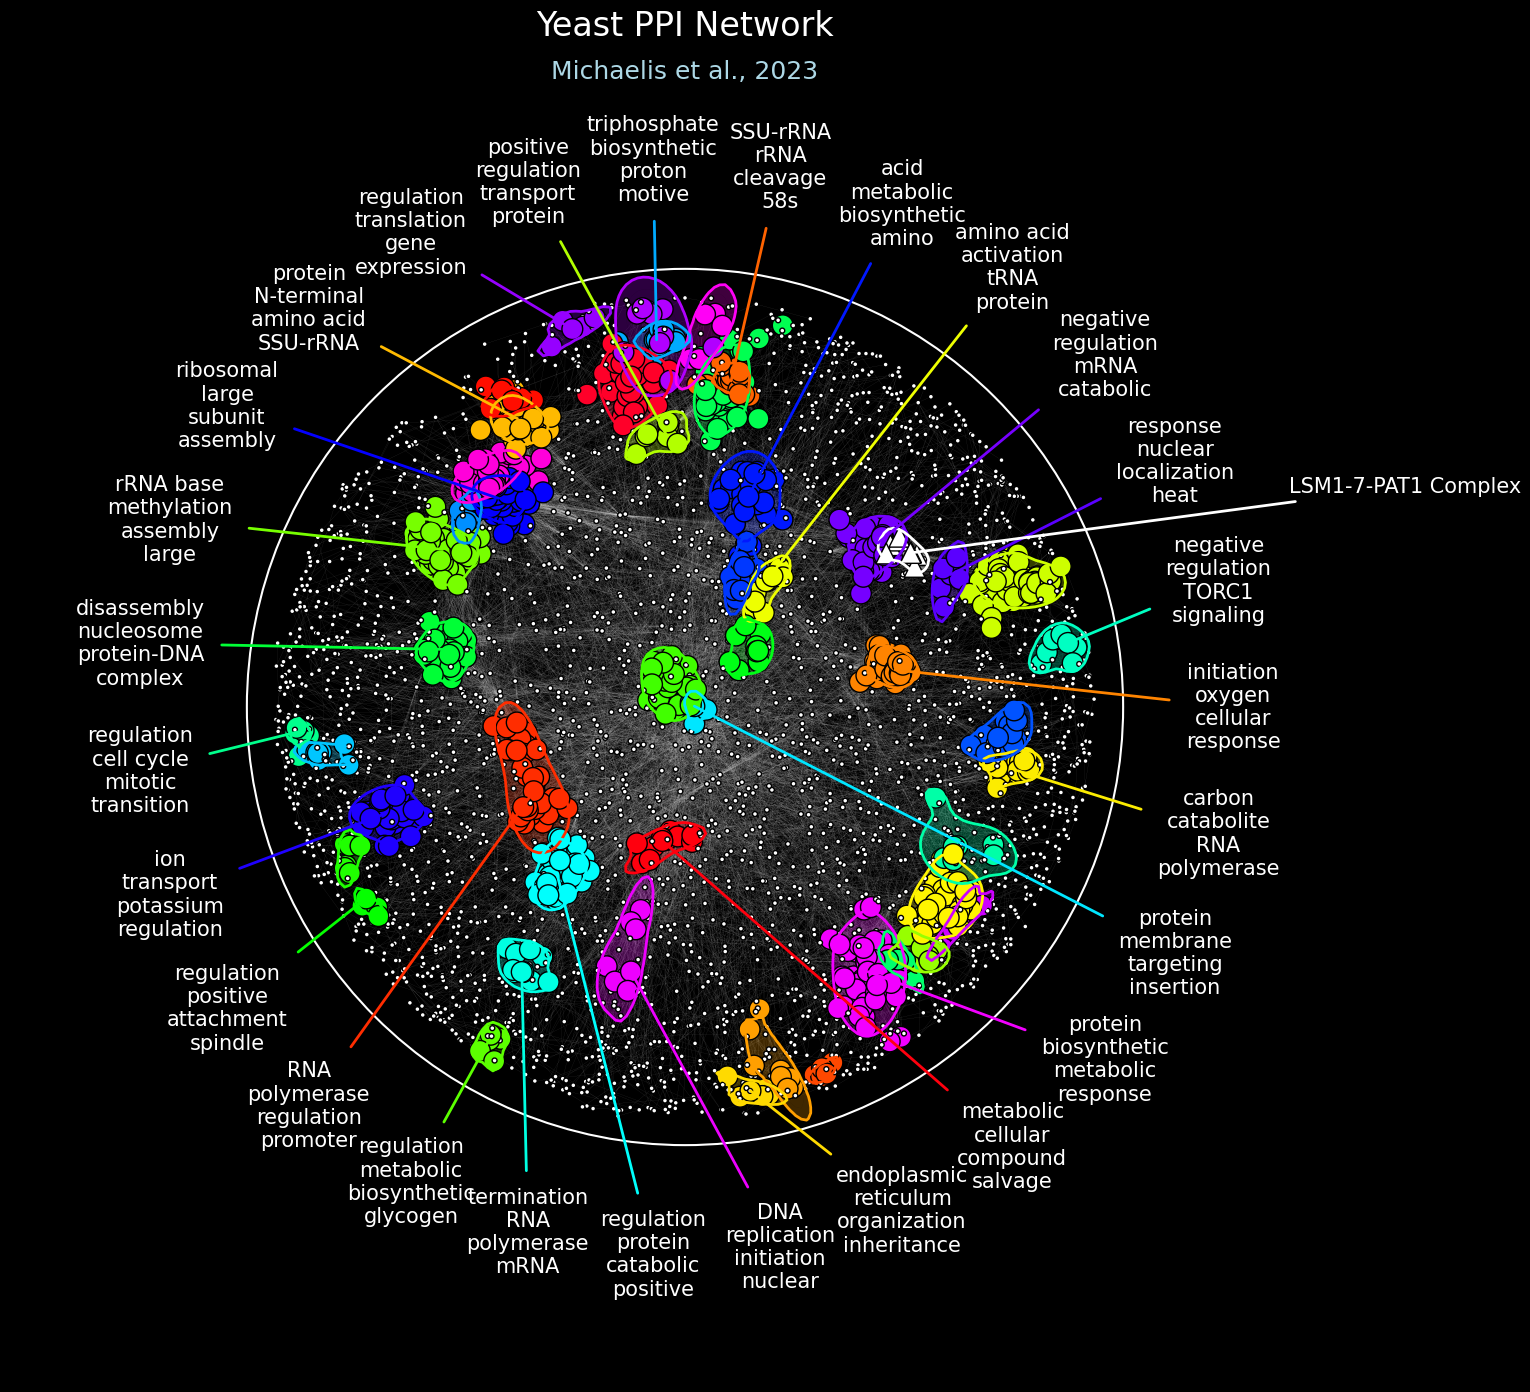

In [24]:
# Display the plot

plotter.show()

## 7. [Troubleshoot] Potential Plotting Issue in Jupyter Notebooks

When using the `NetworkPlotter` class in a Jupyter Notebook, you might notice that the plot is automatically displayed when `plt.subplots` is called during plot initialization. This can result in the plot appearing prematurely in the cell where it's created, even if you intend to display it later using `plotter.show()`.

If you encounter this issue, refer to the following cell to properly display the plot.


---------------
Loading plotter
---------------


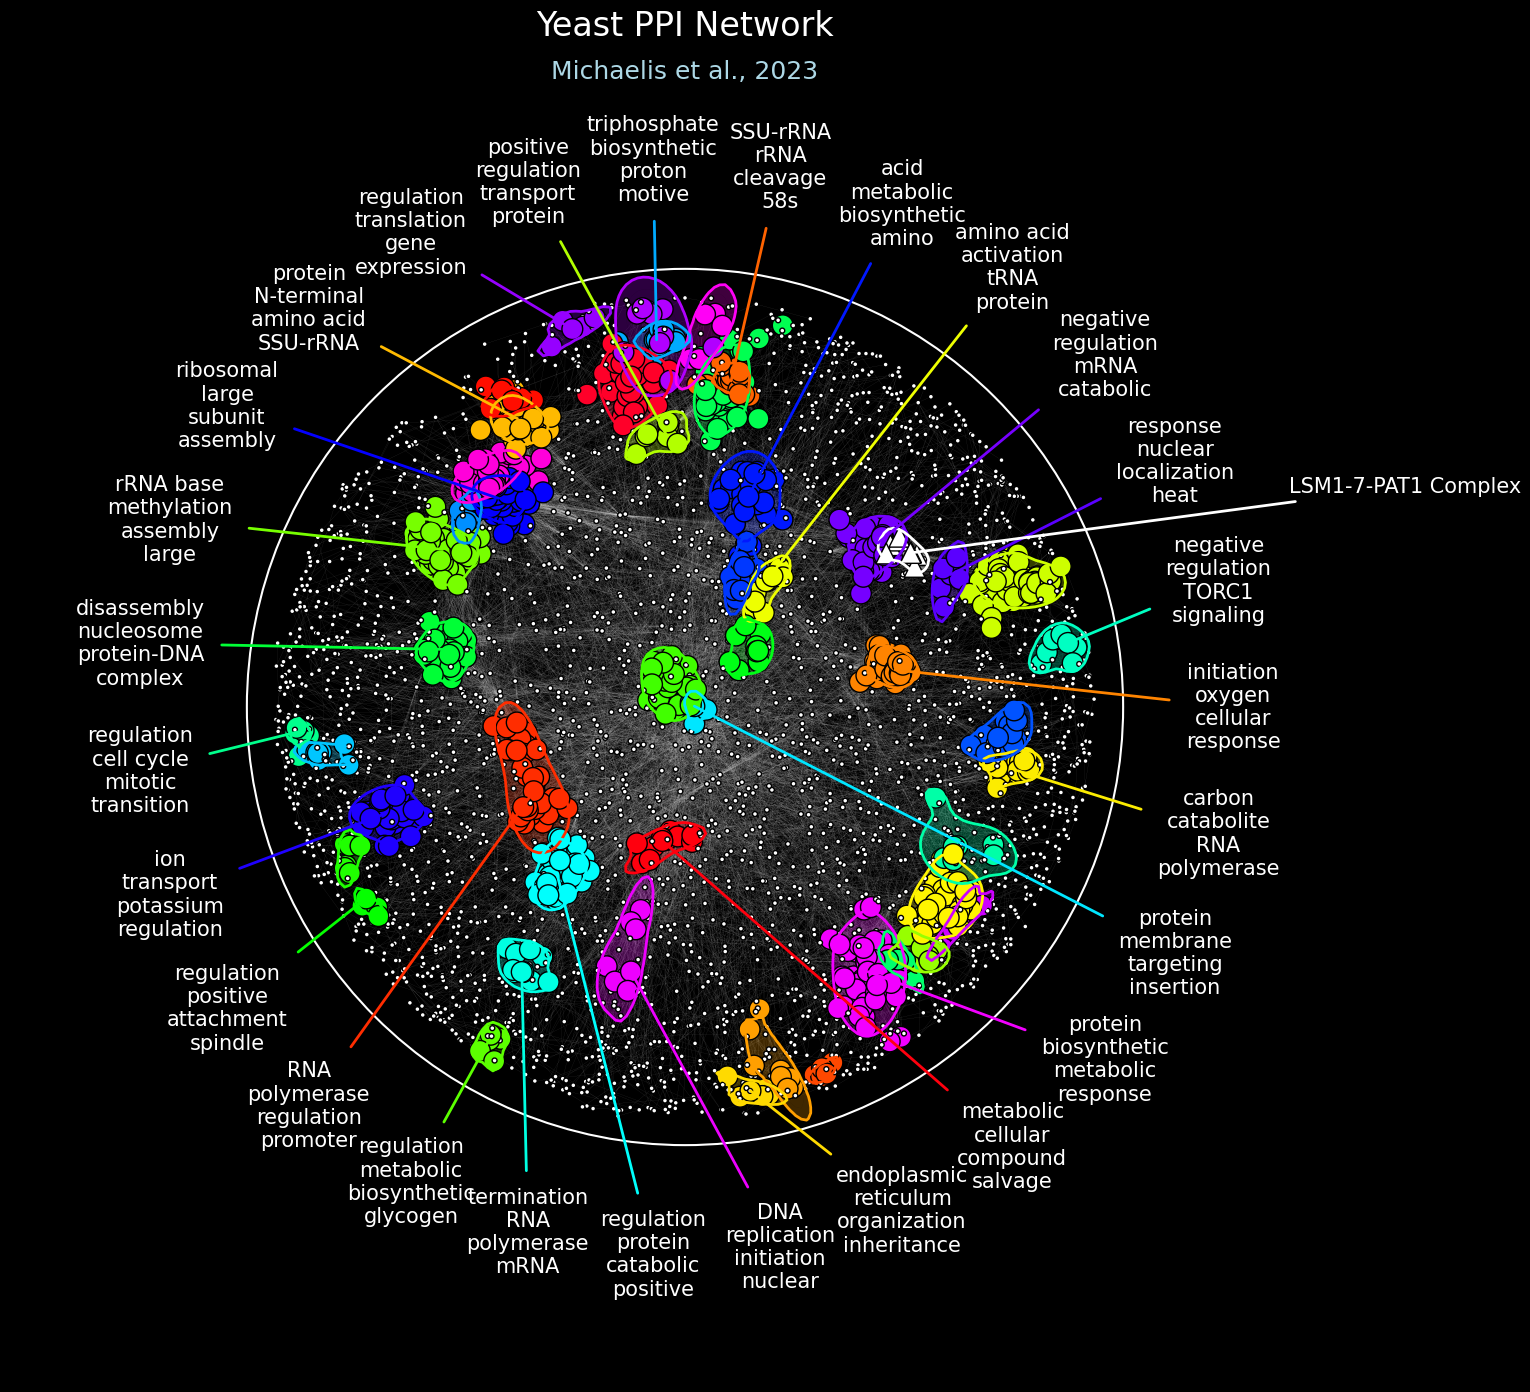

In [25]:
# Set random seed for reproducibility
random_seed = 887

# Initialize the NetworkPlotter with the NetworkGraph object
plotter = risk.load_plotter(
    graph=graph,
    figsize=(15, 15),
    background_color="black",
)

# Plot network title and subtitle
plotter.plot_title(
    title="Yeast PPI Network",
    subtitle="Michaelis et al., 2023",
    title_fontsize=24,
    subtitle_fontsize=18,
    font="DejaVu Sans",
    title_color="white",
    subtitle_color="lightblue",
    title_x=0.5,
    title_y=0.925,
    title_space_offset=0.08,
    subtitle_offset=0.025,
)

# Plot network perimeter as a circle
plotter.plot_circle_perimeter(
    scale=1.02,
    center_offset_x=0.0,
    center_offset_y=0.0,
    linestyle="solid",
    linewidth=1.5,
    color="white",
    outline_alpha=1.0,
    fill_alpha=0.0,
)

# Plot network nodes and edges
plotter.plot_network(
    node_size=plotter.get_annotated_node_sizes(
        significant_size=225,
        nonsignificant_size=12.5,
    ),
    node_shape="o",
    node_edgewidth=1.0,
    edge_width=0.03,
    node_color=plotter.get_annotated_node_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        alpha=1.0,
        nonsignificant_color="white",
        nonsignificant_alpha=0.75,
        ids_to_colors={
            10: "#f200ff",
            32: "#fcec00",
        },
        random_seed=random_seed,
    ),
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)
# Plot a subnetwork with custom node and edge attributes
plotter.plot_subnetwork(
    nodes=[
        "LSM1",
        "LSM2",
        "LSM3",
        "LSM4",
        "LSM5",
        "LSM6",
        "LSM7",
        "PAT1",
    ],
    node_size=225,
    node_shape="^",
    node_edgewidth=1.0,
    edge_width=0.04,
    node_color="white",
    node_edgecolor="black",
    edge_color="white",
    node_alpha=1.0,
    edge_alpha=1.0,
)

# Plot KDE-based contours around network nodes
plotter.plot_contours(
    levels=5,
    bandwidth=0.8,
    grid_size=250,
    color=plotter.get_annotated_contour_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        ids_to_colors={
            10: "#f200ff",
            32: "#fcec00",
        },
        random_seed=random_seed,
    ),
    linestyle="solid",
    linewidth=2.0,
    alpha=1.0,
    fill_alpha=0.25,
)

# Plot custom KDE-based contours around a subset of nodes
plotter.plot_subcontour(
    nodes=[
        "LSM1",
        "LSM2",
        "LSM3",
        "LSM4",
        "LSM5",
        "LSM6",
        "LSM7",
        "PAT1",
    ],
    levels=5,
    bandwidth=0.8,
    grid_size=250,
    color="white",
    linestyle="solid",
    linewidth=2.0,
    alpha=1.0,
    fill_alpha=0.25,
)

# Plot labels on the network
plotter.plot_labels(
    scale=1.1,
    offset=0.12,
    font="DejaVu Sans",
    fontcase={"title": "lower"},
    fontsize=15,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=2.0,
    arrow_style="-",
    arrow_color=plotter.get_annotated_label_colors(
        cmap="gist_rainbow",
        color=None,
        blend_colors=False,
        blend_gamma=2.2,
        min_scale=1.0,
        max_scale=1.0,
        scale_factor=0.5,
        ids_to_colors={
            10: "#f200ff",
            32: "#fcec00",
        },
        random_seed=random_seed,
    ),
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
    max_labels=28,
    min_label_lines=3,
    max_label_lines=4,
    min_chars_per_line=3,
    max_chars_per_line=12,
    words_to_omit=["from", "the", "into", "via", "novo", "process", "activity"],
    overlay_ids=False,
    ids_to_keep=None,
    ids_to_labels=None,
)

# Plot sublabels on the network
plotter.plot_sublabel(
    nodes=[
        "LSM1",
        "LSM2",
        "LSM3",
        "LSM4",
        "LSM5",
        "LSM6",
        "LSM7",
        "PAT1",
    ],
    label="LSM1-7-PAT1 Complex",
    radial_position=73,
    scale=1.6,
    offset=0.12,
    font="DejaVu Sans",
    fontsize=15,
    fontcolor="white",
    fontalpha=1.0,
    arrow_linewidth=2.0,
    arrow_style="-",
    arrow_color="white",
    arrow_alpha=1.0,
    arrow_base_shrink=10.0,
    arrow_tip_shrink=0.0,
)

# Display the plot
plotter.show()

---

## 8. Overview of `risk.params`

The `risk.params` module manages and exports analysis parameters, supporting inspection, saving, and sharing to improve reproducibility. _Note: Reloading a RISK instance from a saved parameter file is not currently supported._

### Loading Parameters

The `load` method imports parameters from a predefined source, converting any `np.ndarray` values to lists for easier processing.

#### Returns

- **`dict`**: A dictionary containing the processed parameters.

##### [Back to Top](#risk-network-tutorial-and-examples)

In [26]:
import pandas as pd
from IPython.display import display

# Load the parameters into a dictionary
loaded_params = risk.params.load()

# Display parameters in a tidy table for Jupyter documentation purposes
# This is intended for clarity in notebook examples, not for full inspection of nested fields
pd.set_option("display.max_colwidth", 200)
display(pd.DataFrame(list(loaded_params.items()), columns=["Parameter", "Value"]))
pd.reset_option("display.max_colwidth")

------------------
Loading parameters
------------------


,Parameter,Value
0,annotation,"{'filetype': 'JSON', 'filepath': './data/json/annotation/go_biological_process.json', 'min_nodes_per_term': 5, 'max_nodes_per_term': 75}"
1,datetime,2025-09-29 18:28:41
2,graph,"{'tail': 'right', 'pval_cutoff': 0.01, 'fdr_cutoff': 1.0, 'impute_depth': 0, 'prune_threshold': 0.1, 'linkage_criterion': 'distance', 'linkage_method': 'single', 'linkage_metric': 'sokalmichener',..."
3,neighborhoods,"{'distance_metric': 'louvain', 'louvain_resolution': 5.0, 'leiden_resolution': 1.0, 'fraction_shortest_edges': 0.225, 'statistical_test_function': 'permutation', 'null_distribution': 'network', 'r..."
4,network,"{'compute_sphere': True, 'surface_depth': 0.1, 'min_edges_per_node': 1, 'filetype': 'Cytoscape', 'filepath': './data/cytoscape/michaelis_2023.cys'}"
5,plotter,"{'figsize': (15, 15), 'background_color': 'black', 'background_alpha': 1.0, 'pad': 0.3, 'title': 'Yeast PPI Network', 'subtitle': 'Michaelis et al., 2023', 'title_fontsize': 24, 'subtitle_fontsize..."


### Exporting Parameters to CSV

The `to_csv` method exports the parameters to a CSV file.

#### Parameters

- **`filepath` (str)**: The path where the CSV file will be saved.


In [27]:
# Export parameters to a CSV file

risk.params.to_csv(filepath="./data/csv/params/michaelis_2023.csv")

------------------
Loading parameters
------------------
Parameters exported to CSV file: ./data/csv/params/michaelis_2023.csv


### Exporting Parameters to JSON

The `to_json` method exports the parameters to a JSON file, preserving the hierarchical structure of the data.

#### Parameters

- **`filepath` (str)**: The path where the JSON file will be saved.


In [28]:
# Export parameters to a JSON file

risk.params.to_json(filepath="./data/json/params/michaelis_2023.json")

------------------
Loading parameters
------------------
Parameters exported to JSON file: ./data/json/params/michaelis_2023.json


### Exporting Parameters to Text

The `to_txt` method exports the parameters to a plain text file in a human-readable format.

#### Parameters

- **`filepath` (str)**: The path where the text file will be saved.


In [29]:
# Export parameters to a text file

risk.params.to_txt(filepath="./data/txt/params/michaelis_2023.txt")

------------------
Loading parameters
------------------
Parameters exported to text file: ./data/txt/params/michaelis_2023.txt
